In [1]:
# 1) 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.covariance import LedoitWolf

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

# 한글 폰트 자동 설정 (Windows/macOS/Linux 순으로 후보 탐색)
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "NanumBarunGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    available = {f.name for f in fm.fontManager.ttflist}
    for name in candidates:
        if name in available:
            plt.rcParams["font.family"] = name
            plt.rcParams["axes.unicode_minus"] = False
            return name
    plt.rcParams["axes.unicode_minus"] = False
    return None

_KR_FONT = setup_korean_font()
if _KR_FONT is None:
    print("경고: 사용 가능한 한글 폰트를 찾지 못했습니다. 그래프 한글이 깨질 수 있습니다.")

In [2]:
# 2) 파일 경로 선언 및 로드
EMBEDDING_PATH = "data/kospidaq_embeddings_OpenAI.xlsx"
RETURN_PATH = "data/report_return_mapping.xlsx"
ADJ_CLOSE_PATH = "data/adj_close_wide_2014_2026.xlsx"
MCAP_PATH = "data/market_cap_2014_2025.xlsx"
RISK_FREE_PATH = "data/treasury3m_proxy_krx_20130102_20251230.xlsx"

df_embed_raw = pd.read_excel(EMBEDDING_PATH)
df_ret_raw = pd.read_excel(RETURN_PATH)
df_px_raw = pd.read_excel(ADJ_CLOSE_PATH, index_col=0)
df_mc_raw = pd.read_excel(MCAP_PATH, index_col=0)
df_rf_raw = pd.read_excel(RISK_FREE_PATH, index_col=0)

df_embed_raw

,date,ticker,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536
0,2025-12-30,제이투케이바이오,0.002818,-0.025671,0.019250,-0.015114,-0.021794,-0.000041,0.006391,-0.006771,...,0.004799,-0.021916,0.024311,0.007462,0.006357,0.001155,-2.017493e-02,0.024161,-0.010189,-0.014638
1,2025-12-30,대한항공,-0.008313,-0.029964,0.023021,-0.031660,-0.007354,-0.013455,-0.016913,-0.012554,...,0.004176,-0.007008,0.040848,0.010708,0.009853,-0.008992,-1.781376e-02,0.002246,0.002209,0.006499
2,2025-12-30,LG이노텍,-0.009318,-0.016776,-0.005554,-0.026072,-0.033964,0.013587,-0.035452,-0.001840,...,-0.007300,-0.024268,0.028593,-0.001506,0.001988,0.008615,-3.305544e-02,0.008078,0.000484,-0.002896
3,2025-12-30,삼양식품,-0.028252,-0.034510,0.015855,-0.028252,-0.029229,0.012529,-0.040398,0.004555,...,0.001764,-0.024093,0.024159,0.019750,0.010548,-0.007373,-2.724863e-02,0.008594,0.016978,-0.004627
4,2025-12-30,KT,-0.017662,-0.016917,0.008262,-0.041310,-0.009637,-0.007754,-0.035675,0.000825,...,-0.017242,-0.009075,0.055585,0.004348,0.012989,0.005492,-2.181962e-02,0.001752,0.014871,0.001962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62445,2013-08-16,현대하이스코,-0.024838,-0.032118,-0.003193,-0.019766,-0.013322,0.022094,-0.022134,0.001869,...,0.009535,-0.033456,0.039558,-0.003804,0.002155,-0.015095,-1.508192e-02,0.002613,0.010498,0.011596
62446,2013-08-16,오리온,-0.005961,-0.020193,0.020931,-0.026096,-0.008882,-0.005729,-0.011586,0.007816,...,0.012371,-0.027277,0.029947,-0.009727,0.003958,-0.001741,-1.214257e-02,0.028659,0.000126,-0.001907
62447,2013-08-16,신세계,-0.022820,-0.032110,0.020616,-0.029352,-0.022124,0.019109,-0.011622,-0.000723,...,0.008472,-0.024623,0.032316,-0.016416,0.014096,0.022510,-1.642850e-02,0.001619,0.028579,0.000686
62448,2013-08-16,롯데칠성,-0.016238,-0.013909,0.027321,-0.023907,0.000069,0.006205,-0.013958,0.017274,...,0.027224,-0.014649,0.027072,-0.011601,0.016860,-0.011021,-4.706540e-07,-0.000818,0.010358,0.006022


In [3]:
# 3) 임베딩과 수익률 결합
RAW_TARGET_RETURN_COL = "log_return_1"
embedding_cols = [c for c in df_embed_raw.columns if str(c).startswith("embedding_")]

df_concat = pd.concat(
    [
        df_embed_raw[["date", "ticker"] + embedding_cols],
        df_ret_raw[["ticker_code", RAW_TARGET_RETURN_COL]],
    ],
    axis=1,
)

df_concat["date"] = pd.to_datetime(df_concat["date"], errors="coerce")
df_concat["ticker_code"] = pd.to_numeric(df_concat["ticker_code"], errors="coerce")
df_concat[RAW_TARGET_RETURN_COL] = pd.to_numeric(df_concat[RAW_TARGET_RETURN_COL], errors="coerce")

df_concat

,date,ticker,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,ticker_code,log_return_1
0,2025-12-30,제이투케이바이오,0.002818,-0.025671,0.019250,-0.015114,-0.021794,-0.000041,0.006391,-0.006771,...,0.024311,0.007462,0.006357,0.001155,-2.017493e-02,0.024161,-0.010189,-0.014638,420570.0,0.049897
1,2025-12-30,대한항공,-0.008313,-0.029964,0.023021,-0.031660,-0.007354,-0.013455,-0.016913,-0.012554,...,0.040848,0.010708,0.009853,-0.008992,-1.781376e-02,0.002246,0.002209,0.006499,3490.0,-0.015643
2,2025-12-30,LG이노텍,-0.009318,-0.016776,-0.005554,-0.026072,-0.033964,0.013587,-0.035452,-0.001840,...,0.028593,-0.001506,0.001988,0.008615,-3.305544e-02,0.008078,0.000484,-0.002896,11070.0,-0.012999
3,2025-12-30,삼양식품,-0.028252,-0.034510,0.015855,-0.028252,-0.029229,0.012529,-0.040398,0.004555,...,0.024159,0.019750,0.010548,-0.007373,-2.724863e-02,0.008594,0.016978,-0.004627,3230.0,0.035903
4,2025-12-30,KT,-0.017662,-0.016917,0.008262,-0.041310,-0.009637,-0.007754,-0.035675,0.000825,...,0.055585,0.004348,0.012989,0.005492,-2.181962e-02,0.001752,0.014871,0.001962,30200.0,-0.025025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62445,2013-08-16,현대하이스코,-0.024838,-0.032118,-0.003193,-0.019766,-0.013322,0.022094,-0.022134,0.001869,...,0.039558,-0.003804,0.002155,-0.015095,-1.508192e-02,0.002613,0.010498,0.011596,NaN,NaN
62446,2013-08-16,오리온,-0.005961,-0.020193,0.020931,-0.026096,-0.008882,-0.005729,-0.011586,0.007816,...,0.029947,-0.009727,0.003958,-0.001741,-1.214257e-02,0.028659,0.000126,-0.001907,271560.0,NaN
62447,2013-08-16,신세계,-0.022820,-0.032110,0.020616,-0.029352,-0.022124,0.019109,-0.011622,-0.000723,...,0.032316,-0.016416,0.014096,0.022510,-1.642850e-02,0.001619,0.028579,0.000686,4170.0,NaN
62448,2013-08-16,롯데칠성,-0.016238,-0.013909,0.027321,-0.023907,0.000069,0.006205,-0.013958,0.017274,...,0.027072,-0.011601,0.016860,-0.011021,-4.706540e-07,-0.000818,0.010358,0.006022,5300.0,NaN


C:\Users\82105\AppData\Local\Temp\ipykernel_22132\537487907.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = universe_daily_count["n_tickers_ge_min_report"].resample("M").mean().to_frame("value")


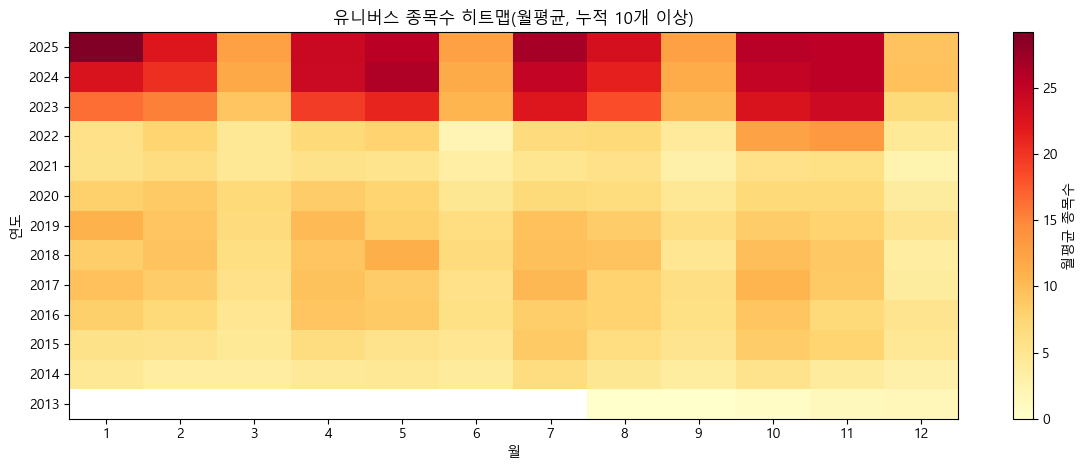

In [4]:
# 4) 유니버스 통계 계산
MIN_REPORT_COUNT = 10

# 유니버스 카운트는 date/ticker_code 기준으로만 계산
# (log_return_1 결측이어도 리포트 개수에는 포함)
df_stat = df_concat.dropna(subset=["date", "ticker_code"]).copy()
df_stat["date"] = pd.to_datetime(df_stat["date"])
df_stat["ticker_code"] = df_stat["ticker_code"].astype(int).astype(str).str.zfill(6)

daily_report_count = (
    df_stat.groupby(["ticker_code", "date"], as_index=False)
    .size()
    .rename(columns={"size": "n_reports_day"})
    .sort_values(["ticker_code", "date"])
)
daily_report_count["cum_reports"] = daily_report_count.groupby("ticker_code")["n_reports_day"].cumsum()

universe_daily_count = (
    daily_report_count.assign(is_eligible=daily_report_count["cum_reports"] >= MIN_REPORT_COUNT)
    .groupby("date")["is_eligible"]
    .sum()
    .rename("n_tickers_ge_min_report")
    .to_frame()
    .sort_index()
)

use_kr = ("_KR_FONT" in globals()) and (_KR_FONT is not None)

# 월별 평균으로 집계해 연도 x 월 히트맵으로 표현
monthly = universe_daily_count["n_tickers_ge_min_report"].resample("M").mean().to_frame("value")
monthly["year"] = monthly.index.year
monthly["month"] = monthly.index.month
heat = monthly.pivot(index="year", columns="month", values="value").sort_index()

fig, ax = plt.subplots(figsize=(12, 4.8))
im = ax.imshow(heat.values, aspect="auto", cmap="YlOrRd", origin="lower")

ax.set_xticks(np.arange(12))
ax.set_xticklabels([str(i) for i in range(1, 13)])
ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels(heat.index.astype(str))

if use_kr:
    ax.set_title(f"유니버스 종목수 히트맵(월평균, 누적 {MIN_REPORT_COUNT}개 이상)")
    ax.set_xlabel("월")
    ax.set_ylabel("연도")
    cbar_label = "월평균 종목수"
else:
    ax.set_title(f"Universe Size Heatmap (Monthly Mean, cum>={MIN_REPORT_COUNT})")
    ax.set_xlabel("Month")
    ax.set_ylabel("Year")
    cbar_label = "Monthly mean #tickers"

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(cbar_label)
plt.tight_layout()
plt.show()

In [5]:
# 5) 유니버스 필터 적용
ticker_eligible_from = (
    daily_report_count[daily_report_count["cum_reports"] >= MIN_REPORT_COUNT]
    .groupby("ticker_code")["date"]
    .min()
    .sort_index()
)

df_universe = df_stat.copy()
df_universe["eligible_from"] = df_universe["ticker_code"].map(ticker_eligible_from)
df_universe = df_universe[df_universe["eligible_from"].notna() & (df_universe["date"] >= df_universe["eligible_from"])].copy()

df_universe

,date,ticker,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,ticker_code,log_return_1,eligible_from
1,2025-12-30,대한항공,-0.008313,-0.029964,0.023021,-0.031660,-0.007354,-0.013455,-0.016913,-0.012554,...,0.010708,0.009853,-0.008992,-0.017814,0.002246,0.002209,0.006499,003490,-0.015643,2013-10-25
2,2025-12-30,LG이노텍,-0.009318,-0.016776,-0.005554,-0.026072,-0.033964,0.013587,-0.035452,-0.001840,...,-0.001506,0.001988,0.008615,-0.033055,0.008078,0.000484,-0.002896,011070,-0.012999,2013-10-25
3,2025-12-30,삼양식품,-0.028252,-0.034510,0.015855,-0.028252,-0.029229,0.012529,-0.040398,0.004555,...,0.019750,0.010548,-0.007373,-0.027249,0.008594,0.016978,-0.004627,003230,0.035903,2020-07-08
4,2025-12-30,KT,-0.017662,-0.016917,0.008262,-0.041310,-0.009637,-0.007754,-0.035675,0.000825,...,0.004348,0.012989,0.005492,-0.021820,0.001752,0.014871,0.001962,030200,-0.025025,2013-11-11
5,2025-12-30,컴투스,-0.019568,-0.028985,-0.000856,-0.021582,-0.011852,0.008212,-0.019609,-0.003353,...,-0.001283,-0.006117,0.007328,-0.026385,0.007913,0.005525,0.009165,078340,0.030511,2014-10-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61985,2013-10-21,하나금융지주,-0.019276,-0.011821,0.011939,-0.015670,-0.005458,0.024237,-0.007482,-0.018792,...,-0.019166,0.018571,0.004674,-0.015877,-0.007089,0.022247,0.017466,086790,NaN,2013-10-21
61987,2013-10-21,LG화학,-0.011408,-0.017718,0.010332,-0.030632,-0.017400,0.018236,-0.019789,0.001685,...,-0.011839,0.007333,-0.009563,-0.018740,0.001340,0.007187,0.010425,051910,NaN,2013-10-21
61989,2013-10-21,LG화학,-0.000693,-0.013393,0.018683,-0.017941,-0.008917,0.020394,-0.022900,-0.013101,...,-0.018869,0.005470,-0.006862,-0.025645,0.004359,0.001759,-0.000491,051910,NaN,2013-10-21
61990,2013-10-21,하나금융지주,-0.006231,-0.024012,0.011144,-0.005262,-0.014413,0.001661,-0.035556,-0.010392,...,0.014006,0.005055,-0.013675,-0.007386,0.003572,0.021309,0.016302,086790,NaN,2013-10-21


In [6]:
# 6) 결측치 처리
need_cols = ["date", "ticker_code", RAW_TARGET_RETURN_COL] + embedding_cols
df_missing_clean = df_universe.dropna(subset=need_cols).copy()

pd.DataFrame([
    {
        "rows_before": len(df_universe),
        "rows_after": len(df_missing_clean),
        "rows_removed": len(df_universe) - len(df_missing_clean),
    }
])

,rows_before,rows_after,rows_removed
0,44217,43607,610


In [7]:
# 7) 중복 리포트 평균
a = {c: "mean" for c in embedding_cols}
a[RAW_TARGET_RETURN_COL] = "mean"
df_dedup = df_missing_clean.groupby(["date", "ticker_code"], as_index=False).agg(a)

df_dedup

,date,ticker_code,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,log_return_1
0,2014-01-02,009150,-0.027146,-0.042794,0.004794,-0.025983,-0.003344,0.009066,-0.026578,0.011676,...,-0.019335,0.032538,0.004107,0.028520,0.005508,-0.022282,0.015185,0.002620,0.020710,-0.002874
1,2014-01-02,036460,0.009898,-0.011544,0.013522,-0.035531,-0.016076,0.002150,-0.026201,-0.009451,...,0.000867,0.029701,-0.015060,-0.008251,-0.011929,-0.003690,-0.002951,0.006252,0.000763,-0.001491
2,2014-01-03,005930,-0.014437,-0.015437,-0.006482,-0.029585,-0.003905,0.000510,-0.023142,0.007107,...,-0.033898,0.038684,0.004852,0.021604,-0.010401,-0.024339,0.028349,0.017409,0.016186,0.008452
3,2014-01-03,011070,0.002579,-0.016928,0.005598,-0.030810,-0.001592,0.005821,-0.038086,-0.002132,...,-0.004377,0.046832,0.004475,-0.005503,0.007768,0.000315,0.000623,0.026214,0.009659,-0.008408
4,2014-01-03,015760,-0.018502,-0.047177,-0.003536,-0.034663,-0.010361,0.001698,-0.019592,0.008740,...,-0.001579,0.042306,0.006641,-0.011552,0.015300,-0.020548,0.004609,0.005012,0.015946,0.028779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28376,2025-12-30,011070,-0.009318,-0.016776,-0.005554,-0.026072,-0.033964,0.013587,-0.035452,-0.001840,...,-0.024268,0.028593,-0.001506,0.001988,0.008615,-0.033055,0.008078,0.000484,-0.002896,-0.012999
28377,2025-12-30,030200,-0.017662,-0.016917,0.008262,-0.041310,-0.009637,-0.007754,-0.035675,0.000825,...,-0.009075,0.055585,0.004348,0.012989,0.005492,-0.021820,0.001752,0.014871,0.001962,-0.025025
28378,2025-12-30,060720,-0.000799,-0.037070,0.001431,-0.025897,-0.004132,0.025897,-0.027413,0.010183,...,-0.021212,0.030923,0.002126,0.005962,-0.000551,-0.009896,-0.009056,-0.007082,0.007389,0.018609
28379,2025-12-30,078340,-0.019568,-0.028985,-0.000856,-0.021582,-0.011852,0.008212,-0.019609,-0.003353,...,-0.004317,0.059167,-0.001283,-0.006117,0.007328,-0.026385,0.007913,0.005525,0.009165,0.030511


In [8]:
# 8) 윈저라이즈
RUN_WINSORIZE = False
WINSOR_LOWER_Q = 0.00
WINSOR_UPPER_Q = 1.00

if RUN_WINSORIZE:
    if WINSOR_LOWER_Q > WINSOR_UPPER_Q:
        raise ValueError("WINSOR_LOWER_Q는 WINSOR_UPPER_Q보다 작거나 같아야 합니다.")

    lo = df_dedup[RAW_TARGET_RETURN_COL].quantile(WINSOR_LOWER_Q)
    hi = df_dedup[RAW_TARGET_RETURN_COL].quantile(WINSOR_UPPER_Q)

    df_winsor = df_dedup.copy()
    before = pd.to_numeric(df_winsor[RAW_TARGET_RETURN_COL], errors="coerce")
    after = before.clip(lo, hi)
    df_winsor[RAW_TARGET_RETURN_COL] = after
    clipped_n = int((before.ne(after)).sum())
    mode = "winsorized"
else:
    lo = np.nan
    hi = np.nan
    clipped_n = 0
    mode = "raw"
    df_winsor = df_dedup.copy()

winsor_summary = pd.DataFrame([
    {
        "mode": mode,
        "rows_before": len(df_dedup),
        "rows_after": len(df_winsor),
        "clipped_values": clipped_n,
        "lower_q": WINSOR_LOWER_Q,
        "upper_q": WINSOR_UPPER_Q,
        "lower_value": lo,
        "upper_value": hi,
    }
])

display(winsor_summary)
df_winsor

,mode,rows_before,rows_after,clipped_values,lower_q,upper_q,lower_value,upper_value
0,raw,28381,28381,0,0.0,1.0,NaN,NaN


,date,ticker_code,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,log_return_1
0,2014-01-02,009150,-0.027146,-0.042794,0.004794,-0.025983,-0.003344,0.009066,-0.026578,0.011676,...,-0.019335,0.032538,0.004107,0.028520,0.005508,-0.022282,0.015185,0.002620,0.020710,-0.002874
1,2014-01-02,036460,0.009898,-0.011544,0.013522,-0.035531,-0.016076,0.002150,-0.026201,-0.009451,...,0.000867,0.029701,-0.015060,-0.008251,-0.011929,-0.003690,-0.002951,0.006252,0.000763,-0.001491
2,2014-01-03,005930,-0.014437,-0.015437,-0.006482,-0.029585,-0.003905,0.000510,-0.023142,0.007107,...,-0.033898,0.038684,0.004852,0.021604,-0.010401,-0.024339,0.028349,0.017409,0.016186,0.008452
3,2014-01-03,011070,0.002579,-0.016928,0.005598,-0.030810,-0.001592,0.005821,-0.038086,-0.002132,...,-0.004377,0.046832,0.004475,-0.005503,0.007768,0.000315,0.000623,0.026214,0.009659,-0.008408
4,2014-01-03,015760,-0.018502,-0.047177,-0.003536,-0.034663,-0.010361,0.001698,-0.019592,0.008740,...,-0.001579,0.042306,0.006641,-0.011552,0.015300,-0.020548,0.004609,0.005012,0.015946,0.028779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28376,2025-12-30,011070,-0.009318,-0.016776,-0.005554,-0.026072,-0.033964,0.013587,-0.035452,-0.001840,...,-0.024268,0.028593,-0.001506,0.001988,0.008615,-0.033055,0.008078,0.000484,-0.002896,-0.012999
28377,2025-12-30,030200,-0.017662,-0.016917,0.008262,-0.041310,-0.009637,-0.007754,-0.035675,0.000825,...,-0.009075,0.055585,0.004348,0.012989,0.005492,-0.021820,0.001752,0.014871,0.001962,-0.025025
28378,2025-12-30,060720,-0.000799,-0.037070,0.001431,-0.025897,-0.004132,0.025897,-0.027413,0.010183,...,-0.021212,0.030923,0.002126,0.005962,-0.000551,-0.009896,-0.009056,-0.007082,0.007389,0.018609
28379,2025-12-30,078340,-0.019568,-0.028985,-0.000856,-0.021582,-0.011852,0.008212,-0.019609,-0.003353,...,-0.004317,0.059167,-0.001283,-0.006117,0.007328,-0.026385,0.007913,0.005525,0.009165,0.030511


In [ ]:
# 9) 타깃 생성 (로그초과수익률)
RISK_FREE_TRADING_DAYS = 252

df_rf = df_rf_raw.copy()
df_rf.index = pd.to_datetime(df_rf.index)
df_rf = df_rf.sort_index()
rf_col = "yield_3m_proxy" if "yield_3m_proxy" in df_rf.columns else df_rf.columns[0]
rf_ann = pd.to_numeric(df_rf[rf_col], errors="coerce") / 100.0

# 연율 무위험수익률을 일간 유효수익률로 변환
rf_daily = ((1.0 + rf_ann).clip(lower=1e-12) ** (1.0 / RISK_FREE_TRADING_DAYS) - 1.0).rename("rf_daily")

h = int(RAW_TARGET_RETURN_COL.split("_")[-1]) if RAW_TARGET_RETURN_COL.split("_")[-1].isdigit() else 1
rf_period = rf_daily if h == 1 else (1.0 + rf_daily).rolling(h).apply(np.prod, raw=True) - 1.0

df_target = df_winsor.copy().sort_values(["date", "ticker_code"])
if RAW_TARGET_RETURN_COL.startswith("log_return_"):
    df_target["target_log_raw"] = pd.to_numeric(df_target[RAW_TARGET_RETURN_COL], errors="coerce")
elif RAW_TARGET_RETURN_COL.startswith("simple_return_"):
    df_target["target_log_raw"] = np.log1p(pd.to_numeric(df_target[RAW_TARGET_RETURN_COL], errors="coerce"))
else:
    raise ValueError("RAW_TARGET_RETURN_COL ?? ??")

df_target["rf_period"] = rf_period.reindex(df_target["date"], method="ffill").to_numpy()
df_target["rf_log_period"] = np.log1p(df_target["rf_period"].clip(lower=-0.999999))
df_target["target_log_excess"] = df_target["target_log_raw"] - df_target["rf_log_period"]
MODEL_TARGET_COL = "target_log_excess"
df_target = df_target.dropna(subset=[MODEL_TARGET_COL]).copy()

df_target


,date,ticker_code,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,log_return_1,target_log_raw,rf_period,rf_log_period,target_log_excess
0,2014-01-02,009150,-0.027146,-0.042794,0.004794,-0.025983,-0.003344,0.009066,-0.026578,0.011676,...,0.005508,-0.022282,0.015185,0.002620,0.020710,-0.002874,-0.002874,0.000106,0.000106,-0.002979
1,2014-01-02,036460,0.009898,-0.011544,0.013522,-0.035531,-0.016076,0.002150,-0.026201,-0.009451,...,-0.011929,-0.003690,-0.002951,0.006252,0.000763,-0.001491,-0.001491,0.000106,0.000106,-0.001597
2,2014-01-03,005930,-0.014437,-0.015437,-0.006482,-0.029585,-0.003905,0.000510,-0.023142,0.007107,...,-0.010401,-0.024339,0.028349,0.017409,0.016186,0.008452,0.008452,0.000106,0.000106,0.008346
3,2014-01-03,011070,0.002579,-0.016928,0.005598,-0.030810,-0.001592,0.005821,-0.038086,-0.002132,...,0.007768,0.000315,0.000623,0.026214,0.009659,-0.008408,-0.008408,0.000106,0.000106,-0.008514
4,2014-01-03,015760,-0.018502,-0.047177,-0.003536,-0.034663,-0.010361,0.001698,-0.019592,0.008740,...,0.015300,-0.020548,0.004609,0.005012,0.015946,0.028779,0.028779,0.000106,0.000106,0.028673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28376,2025-12-30,011070,-0.009318,-0.016776,-0.005554,-0.026072,-0.033964,0.013587,-0.035452,-0.001840,...,0.008615,-0.033055,0.008078,0.000484,-0.002896,-0.012999,-0.012999,0.000114,0.000114,-0.013113
28377,2025-12-30,030200,-0.017662,-0.016917,0.008262,-0.041310,-0.009637,-0.007754,-0.035675,0.000825,...,0.005492,-0.021820,0.001752,0.014871,0.001962,-0.025025,-0.025025,0.000114,0.000114,-0.025139
28378,2025-12-30,060720,-0.000799,-0.037070,0.001431,-0.025897,-0.004132,0.025897,-0.027413,0.010183,...,-0.000551,-0.009896,-0.009056,-0.007082,0.007389,0.018609,0.018609,0.000114,0.000114,0.018495
28379,2025-12-30,078340,-0.019568,-0.028985,-0.000856,-0.021582,-0.011852,0.008212,-0.019609,-0.003353,...,0.007328,-0.026385,0.007913,0.005525,0.009165,0.030511,0.030511,0.000114,0.000114,0.030397


In [10]:
# 10) 모델링 데이터 확정
DATA_START_DATE = "2014-01-02"
df_model = df_target[df_target["date"] >= pd.to_datetime(DATA_START_DATE)].copy()

df_model

,date,ticker_code,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,log_return_1,target_log_raw,rf_period,rf_log_period,target_log_excess
0,2014-01-02,009150,-0.027146,-0.042794,0.004794,-0.025983,-0.003344,0.009066,-0.026578,0.011676,...,0.005508,-0.022282,0.015185,0.002620,0.020710,-0.002874,-0.002874,0.000106,0.000106,-0.002979
1,2014-01-02,036460,0.009898,-0.011544,0.013522,-0.035531,-0.016076,0.002150,-0.026201,-0.009451,...,-0.011929,-0.003690,-0.002951,0.006252,0.000763,-0.001491,-0.001491,0.000106,0.000106,-0.001597
2,2014-01-03,005930,-0.014437,-0.015437,-0.006482,-0.029585,-0.003905,0.000510,-0.023142,0.007107,...,-0.010401,-0.024339,0.028349,0.017409,0.016186,0.008452,0.008452,0.000106,0.000106,0.008346
3,2014-01-03,011070,0.002579,-0.016928,0.005598,-0.030810,-0.001592,0.005821,-0.038086,-0.002132,...,0.007768,0.000315,0.000623,0.026214,0.009659,-0.008408,-0.008408,0.000106,0.000106,-0.008514
4,2014-01-03,015760,-0.018502,-0.047177,-0.003536,-0.034663,-0.010361,0.001698,-0.019592,0.008740,...,0.015300,-0.020548,0.004609,0.005012,0.015946,0.028779,0.028779,0.000106,0.000106,0.028673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28376,2025-12-30,011070,-0.009318,-0.016776,-0.005554,-0.026072,-0.033964,0.013587,-0.035452,-0.001840,...,0.008615,-0.033055,0.008078,0.000484,-0.002896,-0.012999,-0.012999,0.000114,0.000114,-0.013113
28377,2025-12-30,030200,-0.017662,-0.016917,0.008262,-0.041310,-0.009637,-0.007754,-0.035675,0.000825,...,0.005492,-0.021820,0.001752,0.014871,0.001962,-0.025025,-0.025025,0.000114,0.000114,-0.025139
28378,2025-12-30,060720,-0.000799,-0.037070,0.001431,-0.025897,-0.004132,0.025897,-0.027413,0.010183,...,-0.000551,-0.009896,-0.009056,-0.007082,0.007389,0.018609,0.018609,0.000114,0.000114,0.018495
28379,2025-12-30,078340,-0.019568,-0.028985,-0.000856,-0.021582,-0.011852,0.008212,-0.019609,-0.003353,...,0.007328,-0.026385,0.007913,0.005525,0.009165,0.030511,0.030511,0.000114,0.000114,0.030397


In [11]:
# 11) 리지 회귀 함수
def run_ridge_expanding_predict(df, embedding_cols, target_return, min_train_dates=252, alpha=10.0, min_train_samples=0):
    d = df.dropna(subset=[target_return]).copy()
    d["date"] = pd.to_datetime(d["date"])
    d["ticker_code"] = d["ticker_code"].astype(str).str.zfill(6)
    d = d.sort_values(["date", "ticker_code"])

    ud = pd.DatetimeIndex(sorted(d["date"].unique()))
    if len(ud) <= min_train_dates:
        raise ValueError("?? ?? ??")

    out = []
    for i in tqdm(range(min_train_dates, len(ud)), desc="Ridge expanding", total=len(ud) - min_train_dates):
        pdt = ud[i]
        tr = ud[:i]
        trb = d[d["date"].isin(tr)].dropna(subset=embedding_cols + [target_return])
        teb = d[d["date"] == pdt].dropna(subset=embedding_cols)
        if len(trb) < min_train_samples or len(teb) == 0:
            continue

        m = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=float(alpha)))])
        m.fit(trb[embedding_cols].values, trb[target_return].values)

        pb = teb[["date", "ticker_code", target_return]].copy()
        pb["pred_return"] = m.predict(teb[embedding_cols].values)
        out.append(pb)

    if len(out) == 0:
        return pd.DataFrame(columns=["date", "ticker_code", target_return, "pred_return"])
    return pd.concat(out, ignore_index=True)

In [ ]:
# 12) 알파 진단 함수
def evaluate_ridge_alpha_grid(df, embedding_cols, target_return, min_train_dates, min_train_samples, alpha_grid):
    s_rows, d_rows = [], []
    for a in tqdm(alpha_grid, desc="Alpha diagnostics", total=len(alpha_grid)):
        pred = run_ridge_expanding_predict(df, embedding_cols, target_return, min_train_dates, float(a), min_train_samples)
        v = pred.dropna(subset=[target_return, "pred_return"]).copy()
        if len(v) == 0:
            continue

        y = v[target_return].astype(float)
        yhat = v["pred_return"].astype(float)
        se = (y - yhat) ** 2
        s_rows.append({
            "alpha": float(a),
            "oos_mse_global": float(se.mean()),
            "oos_r2_global": float(r2_score(y, yhat)) if y.nunique() > 1 else np.nan,
            "pred_rows": int(len(v)),
            "pred_dates": int(v["date"].nunique()),
        })

        for d, g in v.assign(se=se).groupby("date"):
            yd = g[target_return].astype(float).values
            yh = g["pred_return"].astype(float).values
            r2d = np.nan if (len(g) < 2 or np.nanstd(yd) == 0) else float(r2_score(yd, yh))
            d_rows.append({"alpha": float(a), "date": pd.to_datetime(d), "n_pred": int(len(g)), "mse_day": float(g["se"].mean()), "r2_day": r2d})

    s = pd.DataFrame(s_rows).sort_values("alpha").reset_index(drop=True) if len(s_rows) > 0 else pd.DataFrame()
    d = pd.DataFrame(d_rows).sort_values(["alpha", "date"]).reset_index(drop=True) if len(d_rows) > 0 else pd.DataFrame()

    if not s.empty and not d.empty:
        dm = d.groupby("alpha")["mse_day"].mean().rename("oos_mse_daily_mean")
        dr = d.groupby("alpha")["r2_day"].mean().rename("oos_r2_daily_mean")
        s = s.merge(dm, left_on="alpha", right_index=True, how="left").merge(dr, left_on="alpha", right_index=True, how="left")

    return s, d

In [12]:
# 13) 알파 선택
WINDOW = 504
MIN_TRAIN_SAMPLES = 0
RIDGE_ALPHA_DEFAULT = 10.0
RUN_ALPHA_SEARCH = False
ALPHA_GRID = [0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0]
ALPHA_SELECTION_METRIC = "oos_mse_daily_mean"

ridge_alpha_used = float(RIDGE_ALPHA_DEFAULT)
alpha_summary, alpha_daily = pd.DataFrame(), pd.DataFrame()

if RUN_ALPHA_SEARCH:
    alpha_summary, alpha_daily = evaluate_ridge_alpha_grid(df_model, embedding_cols, MODEL_TARGET_COL, WINDOW, MIN_TRAIN_SAMPLES, ALPHA_GRID)
    if not alpha_summary.empty:
        metric = ALPHA_SELECTION_METRIC if ALPHA_SELECTION_METRIC in ["oos_mse_global", "oos_mse_daily_mean"] else "oos_mse_global"
        ridge_alpha_used = float(alpha_summary.sort_values([metric, "alpha"]).iloc[0]["alpha"])

alpha_summary

""


In [ ]:
# 14) XGBoost predict function
def run_xgb_expanding_predict(
    df,
    embedding_cols,
    target_return,
    min_train_dates=252,
    min_train_samples=0,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
):
    try:
        from xgboost import XGBRegressor
    except Exception as e:
        raise ImportError("xgboost is required. Run: pip install xgboost") from e

    d = df.dropna(subset=[target_return]).copy()
    d["date"] = pd.to_datetime(d["date"])
    d["ticker_code"] = d["ticker_code"].astype(str).str.zfill(6)
    d = d.sort_values(["date", "ticker_code"])

    ud = pd.DatetimeIndex(sorted(d["date"].unique()))
    if len(ud) <= min_train_dates:
        raise ValueError("Not enough train dates")

    out = []
    for i in tqdm(range(min_train_dates, len(ud)), desc="XGBoost expanding", total=len(ud) - min_train_dates):
        pdt = ud[i]
        tr = ud[:i]
        trb = d[d["date"].isin(tr)].dropna(subset=embedding_cols + [target_return])
        teb = d[d["date"] == pdt].dropna(subset=embedding_cols)
        if len(trb) < min_train_samples or len(teb) == 0:
            continue

        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=int(n_estimators),
            learning_rate=float(learning_rate),
            max_depth=int(max_depth),
            subsample=float(subsample),
            colsample_bytree=float(colsample_bytree),
            reg_alpha=float(reg_alpha),
            reg_lambda=float(reg_lambda),
            random_state=int(random_state),
            n_jobs=int(n_jobs),
        )
        model.fit(trb[embedding_cols].values, trb[target_return].values)

        pb = teb[["date", "ticker_code", target_return]].copy()
        pb["pred_return"] = model.predict(teb[embedding_cols].values)
        out.append(pb)

    if len(out) == 0:
        return pd.DataFrame(columns=["date", "ticker_code", target_return, "pred_return"])
    return pd.concat(out, ignore_index=True)

In [13]:
# 15) Model select (ridge/xgboost)
MODEL_TYPE = "ridge"   # "ridge" or "xgboost"

XGB_PARAMS = {
    "n_estimators": 300,
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
    "random_state": 42,
    "n_jobs": -1,
}

if MODEL_TYPE == "ridge":
    df_pred = run_ridge_expanding_predict(
        df_model,
        embedding_cols,
        MODEL_TARGET_COL,
        WINDOW,
        float(ridge_alpha_used),
        MIN_TRAIN_SAMPLES,
    )
elif MODEL_TYPE == "xgboost":
    df_pred = run_xgb_expanding_predict(
        df=df_model,
        embedding_cols=embedding_cols,
        target_return=MODEL_TARGET_COL,
        min_train_dates=WINDOW,
        min_train_samples=MIN_TRAIN_SAMPLES,
        **XGB_PARAMS,
    )
else:
    raise ValueError("MODEL_TYPE must be ridge or xgboost")

df_view = df_pred.groupby(["date", "ticker_code"], as_index=False).agg({"pred_return": "mean"})

model_run_summary = pd.Series({
    "MODEL_TYPE": MODEL_TYPE,
    "pred_rows": len(df_pred),
    "pred_dates": int(df_pred["date"].nunique()) if not df_pred.empty else 0,
    "target_col": MODEL_TARGET_COL,
})

print(model_run_summary.to_string())
df_view

Ridge expanding:   0%|          | 0/2407 [00:00<?, ?it/s]

MODEL_TYPE                ridge
pred_rows                 25738
pred_dates                 2407
target_col    target_log_excess


,date,ticker_code,pred_return
0,2016-02-03,002350,-0.025500
1,2016-02-03,003490,0.012397
2,2016-02-03,011170,-0.004619
3,2016-02-03,017670,0.001523
4,2016-02-03,046890,0.001426
...,...,...,...
25733,2025-12-30,011070,-0.004985
25734,2025-12-30,030200,0.008148
25735,2025-12-30,060720,-0.000287
25736,2025-12-30,078340,0.008010


In [14]:
# 16) 가격 시가총액 정리
px = df_px_raw.copy()
mc = df_mc_raw.copy()
px.index = pd.to_datetime(px.index)
mc.index = pd.to_datetime(mc.index)
px.columns = px.columns.astype(str).str.zfill(6)
mc.columns = mc.columns.astype(str).str.zfill(6)
px = px.sort_index()
mc = mc.sort_index()

px

,000020,000040,000050,000070,000080,000087,000100,000105,000120,000140,...,900310,900340,950130,950140,950160,950170,950190,950200,950210,950220
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,4440,7719,11150,49046,21750,16850,25730,13308,99600,11450,...,NaN,NaN,6998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,4540,7754,11400,47912,21450,16850,25448,13266,101000,11450,...,NaN,NaN,6955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,4555,7754,11650,48513,21700,16400,26506,13294,104000,11400,...,NaN,NaN,6989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,4580,7731,11650,49313,21700,16550,27774,13508,103000,11300,...,NaN,NaN,7083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,4730,7826,11400,49113,21550,16400,28198,13480,104000,11650,...,NaN,NaN,7519,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-05,6190,449,8960,57400,18150,15060,114500,103000,94900,9710,...,603.0,842.0,4380,11380.0,71900.0,3815.0,8530.0,4000.0,13090.0,866.0
2026-01-06,6130,429,8660,57900,18110,15030,114500,102300,94300,9780,...,589.0,830.0,4265,11320.0,69300.0,3730.0,8480.0,3975.0,13000.0,819.0
2026-01-07,6050,424,8550,56900,17860,14930,113200,101800,96000,9600,...,595.0,811.0,4065,11190.0,70700.0,3830.0,8480.0,3820.0,13370.0,800.0


In [15]:
# 17) 백테스트 수익률 패널
BACKTEST_RETURN_COL = "simple_return_1"
ret_simple = px.pct_change()

if BACKTEST_RETURN_COL.startswith("log_return_"):
    h_bt = int(BACKTEST_RETURN_COL.split("_")[-1])
    ret_simple_wide = np.expm1(np.log(px / px.shift(h_bt)))
elif BACKTEST_RETURN_COL.startswith("simple_return_"):
    h_bt = int(BACKTEST_RETURN_COL.split("_")[-1])
    ret_simple_wide = px.pct_change(periods=h_bt)
else:
    raise ValueError("BACKTEST_RETURN_COL ?? ??")

rf_daily_bt = rf_daily.reindex(ret_simple_wide.index).ffill()
rf_period_bt = rf_daily_bt if h_bt == 1 else (1.0 + rf_daily_bt).rolling(h_bt).apply(np.prod, raw=True) - 1.0
ret_wide = ret_simple_wide.sub(rf_period_bt, axis=0)

ret_wide

C:\Users\82105\AppData\Local\Temp\ipykernel_22132\4078659196.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_simple = px.pct_change()
C:\Users\82105\AppData\Local\Temp\ipykernel_22132\4078659196.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_simple_wide = px.pct_change(periods=h_bt)


,000020,000040,000050,000070,000080,000087,000100,000105,000120,000140,...,900310,900340,950130,950140,950160,950170,950190,950200,950210,950220
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.022417,0.004429,0.022316,-0.023227,-0.013899,-0.000106,-0.011066,-0.003262,0.013951,-0.000106,...,NaN,NaN,-0.006250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.003198,-0.000106,0.021824,0.012438,0.011549,-0.026812,0.041469,0.002005,0.029597,-0.004472,...,NaN,NaN,0.004783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.005383,-0.003072,-0.000106,0.016385,-0.000106,0.009041,0.047733,0.015992,-0.009721,-0.008877,...,NaN,NaN,0.013344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.032646,0.012183,-0.021565,-0.004161,-0.007018,-0.009169,0.015161,-0.002178,0.009603,0.030868,...,NaN,NaN,0.061450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-05,-0.003335,0.013430,-0.043871,0.006904,-0.005593,-0.002102,0.014957,0.010681,-0.001167,0.001950,...,-0.000114,0.016794,-0.004659,-0.015685,0.005481,-0.002728,-0.000114,0.012544,-0.034775,0.013938
2026-01-06,-0.009807,-0.044657,-0.033596,0.008597,-0.002318,-0.002106,-0.000114,-0.006910,-0.006436,0.007095,...,-0.023331,-0.014366,-0.026370,-0.005386,-0.036275,-0.022394,-0.005976,-0.006364,-0.006989,-0.054386
2026-01-07,-0.013164,-0.011769,-0.012816,-0.017385,-0.013918,-0.006767,-0.011468,-0.005001,0.017914,-0.018519,...,0.010073,-0.023005,-0.047007,-0.011598,0.020088,0.026696,-0.000114,-0.039108,0.028348,-0.023313


In [16]:
# 18) 뷰 날짜 준비
OMEGA_WARMUP_DAYS = 0

df_view_by_date = {pd.to_datetime(d): g for d, g in df_view.groupby("date")}
all_view_dates = pd.DatetimeIndex(pd.to_datetime(df_view["date"].unique())).sort_values()
if len(all_view_dates) == 0:
    raise ValueError("?? ?? ??")
if len(all_view_dates) <= int(OMEGA_WARMUP_DAYS):
    raise ValueError("OMEGA_WARMUP_DAYS? ?? ?")
backtest_start = all_view_dates[int(OMEGA_WARMUP_DAYS)]
backtest_end = all_view_dates[-1]
view_dates = list(all_view_dates)

pd.DataFrame([{"backtest_start": backtest_start, "backtest_end": backtest_end, "n_view_dates": len(view_dates)}])

,backtest_start,backtest_end,n_view_dates
0,2016-02-03,2025-12-30,2407


In [17]:
# 19) prior 함수
def get_window_returns(ret_wide, view_date, window):
    vd = pd.to_datetime(view_date)
    if vd not in ret_wide.index:
        raise ValueError("view_date ??")
    e = ret_wide.index.get_loc(vd)
    e = e if isinstance(e, (int, np.integer)) else e.start
    s = e - window + 1
    if s < 0:
        raise ValueError("window ??")
    return ret_wide.iloc[s:e + 1]

def compute_prior_at_date(view_date, ret_wide, mc_wide, window, min_coverage, risk_aversion, universe_filter=None):
    rw = get_window_returns(ret_wide, view_date, window)
    min_obs = int(np.ceil(len(rw) * min_coverage))
    valid = rw.notna().sum(axis=0)
    tick_cov = valid[valid >= min_obs].index.tolist()
    tick_mcap = mc_wide.loc[pd.to_datetime(view_date)].dropna().index.tolist()

    if universe_filter is not None:
        uf = set(universe_filter)
        tick_cov = [t for t in tick_cov if t in uf]
        tick_mcap = [t for t in tick_mcap if t in uf]

    tu = sorted(list(set(tick_cov).intersection(set(tick_mcap))))
    if len(tu) < 2:
        raise ValueError("prior ???? ??")

    X = rw[tu].dropna(axis=0, how="any")
    if len(X) < min_obs:
        raise ValueError("?? ??? ??")

    S = LedoitWolf().fit(X.values).covariance_
    mcap_vec = mc_wide.loc[pd.to_datetime(view_date), tu].values.astype(float)
    w_mkt = mcap_vec / np.nansum(mcap_vec)
    Pi = float(risk_aversion) * (S @ w_mkt)

    return tu, S, Pi, w_mkt

In [18]:
# 20) BL 오메가 비용 함수
def align_view_to_prior(df_view_by_date, view_date, tickers_univ):
    t = df_view_by_date.get(pd.to_datetime(view_date))
    if t is None:
        raise ValueError("??? view ??")
    t = t.copy()
    t["ticker_code"] = t["ticker_code"].astype(str).str.zfill(6)
    t = t[t["ticker_code"].isin(set(tickers_univ))].sort_values("ticker_code")
    if len(t) == 0:
        raise ValueError("??? ??")
    return t["ticker_code"].values.astype(str), t["pred_return"].values.astype(float)


def build_pick_matrix(tickers_univ, tickers_view):
    mp = {t: i for i, t in enumerate(tickers_univ)}
    P = np.zeros((len(tickers_view), len(tickers_univ)), dtype=float)
    for i, t in enumerate(tickers_view):
        P[i, mp[t]] = 1.0
    return P


def black_litterman_posterior(Pi, Sigma, P, Q, Omega, tau=0.05):
    St = float(tau) * Sigma
    iS = np.linalg.pinv(St)
    iO = np.linalg.pinv(Omega)
    A = iS + P.T @ iO @ P
    b = iS @ Pi + P.T @ iO @ Q
    return np.linalg.solve(A, b)


def compute_bl_weights(mu_bl, Sigma, risk_aversion, long_only=True, weight_clip=None):
    w = np.linalg.pinv(Sigma) @ mu_bl
    w = w / float(risk_aversion)
    if long_only:
        w = np.clip(w, 0.0, None)
    if weight_clip is not None:
        w = np.clip(w, 0.0, float(weight_clip)) if long_only else np.clip(w, -float(weight_clip), float(weight_clip))
    s = w.sum()
    return (np.ones_like(w) / len(w)) if np.isclose(s, 0) else (w / s)


def get_omega_level(sse, cnt, min_obs, fallback):
    lv = float(sse / cnt) if int(cnt) >= int(min_obs) else float(fallback)
    if (not np.isfinite(lv)) or (lv <= 0):
        lv = float(fallback)
    return max(lv, 1e-8)


def update_omega_state(pred_series, ret_series, sse, cnt, hist, view_date, ret_date):
    c = pred_series.index.intersection(ret_series.index)
    if len(c) == 0:
        return sse, cnt, hist
    err = pred_series.loc[c].to_numpy(dtype=float) - ret_series.loc[c].to_numpy(dtype=float)
    v = np.isfinite(err)
    if not np.any(v):
        return sse, cnt, hist
    mse_day = float(np.mean(np.square(err[v])))
    sse += mse_day
    cnt += 1
    hist.append({"view_date": pd.to_datetime(view_date), "ret_date": pd.to_datetime(ret_date), "mse_day": mse_day, "n_common": int(np.sum(v)), "omega_day_expanding": float(sse / cnt)})
    return sse, cnt, hist


def compute_turnover_and_sell(prev_w, prev_t, new_w, new_t):
    if prev_w is None:
        return float(np.sum(np.abs(new_w))), float(np.sum(new_w))
    if (prev_t is not None) and np.array_equal(prev_t, new_t):
        d = new_w - prev_w
        return float(np.sum(np.abs(d))), float(np.sum(np.clip(-d, 0.0, None)))
    return float(np.sum(np.abs(new_w))), float(np.sum(new_w))


def compute_cost(turnover, sell_turnover, tc_bps=0.0, tax_bps=0.0):
    return float(turnover) * (float(tc_bps) / 10000.0) + float(sell_turnover) * (float(tax_bps) / 10000.0)


def calc_mdd(cum):
    rm = np.maximum.accumulate(cum)
    dd = cum / rm - 1.0
    return dd.min(), dd

In [ ]:
# 21) 백테스트 실행
RISK_AVERSION = 2.5
OMEGA_MIN_OBS = 20
OMEGA_FALLBACK_MSE = 1e-4
MIN_COVERAGE = 0.9
TAU = 1.0
LONG_ONLY = True
WEIGHT_CLIP = None
TRANSACTION_COST_BPS = 0.0
SELL_TAX_BPS = 0.0

ret_index = ret_wide.index
omega_day_sse, omega_day_cnt = 0.0, 0
omega_daily_hist = []
results, weights_hist = [], []
prev_w, prev_tickers = None, None
eligible_from_series = ticker_eligible_from.sort_values() if isinstance(ticker_eligible_from, pd.Series) else pd.Series(dtype="datetime64[ns]")

for view_date in tqdm(view_dates, desc="Backtest", total=len(view_dates)):
    try:
        uf = eligible_from_series.index[eligible_from_series <= pd.to_datetime(view_date)].tolist() if len(eligible_from_series) > 0 else None
        tu, S, Pi, wm = compute_prior_at_date(view_date, ret_simple, mc, WINDOW, MIN_COVERAGE, RISK_AVERSION, uf)
        tv, Qlog = align_view_to_prior(df_view_by_date, view_date, tu)
        Q = np.expm1(np.asarray(Qlog, dtype=float))
        if len(Q) == 0:
            continue
        P = build_pick_matrix(tu, tv)
        tau = (1.0 / len(tu)) if TAU is None else float(TAU)
        omega_level = get_omega_level(omega_day_sse, omega_day_cnt, OMEGA_MIN_OBS, OMEGA_FALLBACK_MSE)
        Omega = np.eye(len(Q), dtype=float) * omega_level

        live = pd.to_datetime(view_date) >= pd.to_datetime(backtest_start)
        if live:
            mu = black_litterman_posterior(Pi, S, P, Q, Omega, tau)
            w = compute_bl_weights(mu, S, RISK_AVERSION, LONG_ONLY, WEIGHT_CLIP)
            w_bm = wm / np.sum(wm) if not np.isclose(np.sum(wm), 0) else np.ones_like(wm) / len(wm)
        else:
            w, w_bm = None, None
    except Exception:
        continue

    if view_date not in ret_index:
        continue
    loc = ret_index.get_loc(view_date)
    loc = loc if isinstance(loc, (int, np.integer)) else loc.start
    ret_pos = loc + h_bt
    if ret_pos >= len(ret_index):
        continue

    ret_date = ret_index[ret_pos]
    ret_vec = ret_wide.loc[ret_date, tu].values.astype(float)
    tick_ret = np.array(tu, dtype=str)

    ps = pd.Series(Q, index=tv)
    rs = pd.Series(ret_vec, index=tick_ret)
    omega_day_sse, omega_day_cnt, omega_daily_hist = update_omega_state(ps, rs, omega_day_sse, omega_day_cnt, omega_daily_hist, view_date, ret_date)

    if pd.to_datetime(view_date) < pd.to_datetime(backtest_start):
        continue

    if np.isnan(ret_vec).any():
        m = ~np.isnan(ret_vec)
        if m.sum() < 2:
            continue
        ret_vec = ret_vec[m]
        w = w[m]
        w = w / w.sum()
        w_bm = w_bm[m]
        w_bm = w_bm / w_bm.sum()
        tick_ret = tick_ret[m]

    turnover, sell_turnover = compute_turnover_and_sell(prev_w, prev_tickers, w, tick_ret)
    cost = compute_cost(turnover, sell_turnover, TRANSACTION_COST_BPS, SELL_TAX_BPS)
    port_ret = float(np.dot(w, ret_vec)) - cost
    bm_ret = float(np.dot(w_bm, ret_vec))

    results.append({"view_date": pd.to_datetime(view_date), "next_date": pd.to_datetime(ret_date), "net_ret": port_ret, "bm_ret": bm_ret, "cost": cost, "omega_used": omega_level, "n_assets": len(w)})
    weights_hist.append(pd.DataFrame({"date": pd.to_datetime(view_date), "ticker_code": tick_ret, "weight": w}))
    prev_w, prev_tickers = w, tick_ret

if len(results) == 0:
    df_bt = pd.DataFrame(); weights_history = pd.DataFrame(); omega_daily = pd.DataFrame()
else:
    df_bt = pd.DataFrame(results).sort_values("next_date").set_index("next_date")
    weights_history = pd.concat(weights_hist, ignore_index=True)
    omega_daily = pd.DataFrame(omega_daily_hist)

df_bt

Backtest:   0%|          | 0/2407 [00:00<?, ?it/s]

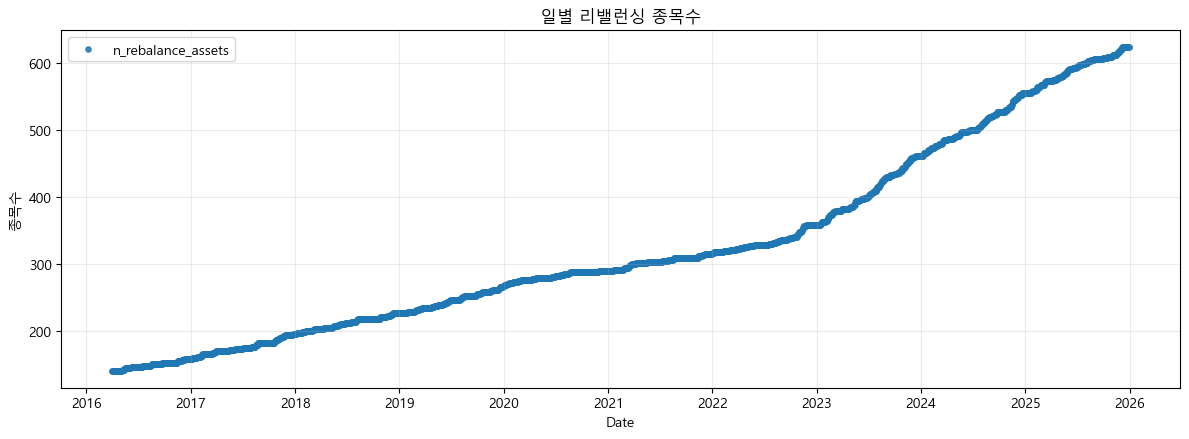

In [ ]:
# 21-1) 일별 리밸런싱 종목수 점그래프
if ("df_bt" not in globals()) or (not isinstance(df_bt, pd.DataFrame)) or df_bt.empty:
    print("먼저 # 21) 백테스트 실행 셀을 실행하세요.")
else:
    if "view_date" not in df_bt.columns or "n_assets" not in df_bt.columns:
        print("df_bt에 view_date 또는 n_assets 컬럼이 없습니다.")
    else:
        rebalance_daily_count = (
            df_bt.reset_index()
            .assign(view_date=lambda x: pd.to_datetime(x["view_date"]))
            .groupby("view_date")["n_assets"]
            .mean()
            .rename("n_rebalance_assets")
            .to_frame()
            .sort_index()
        )

        use_kr = ("_KR_FONT" in globals()) and (_KR_FONT is not None)
        if use_kr:
            title_txt = "일별 리밸런싱 종목수"
            y_txt = "종목수"
            label_txt = "n_rebalance_assets"
        else:
            title_txt = "Daily rebalancing assets"
            y_txt = "Number of assets"
            label_txt = "n_rebalance_assets"

        plt.figure(figsize=(12, 4.5))
        plt.scatter(rebalance_daily_count.index, rebalance_daily_count["n_rebalance_assets"], s=14, alpha=0.85, label=label_txt)
        plt.title(title_txt)
        plt.xlabel("Date")
        plt.ylabel(y_txt)
        plt.grid(alpha=0.25)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.show()

        rebalance_daily_count


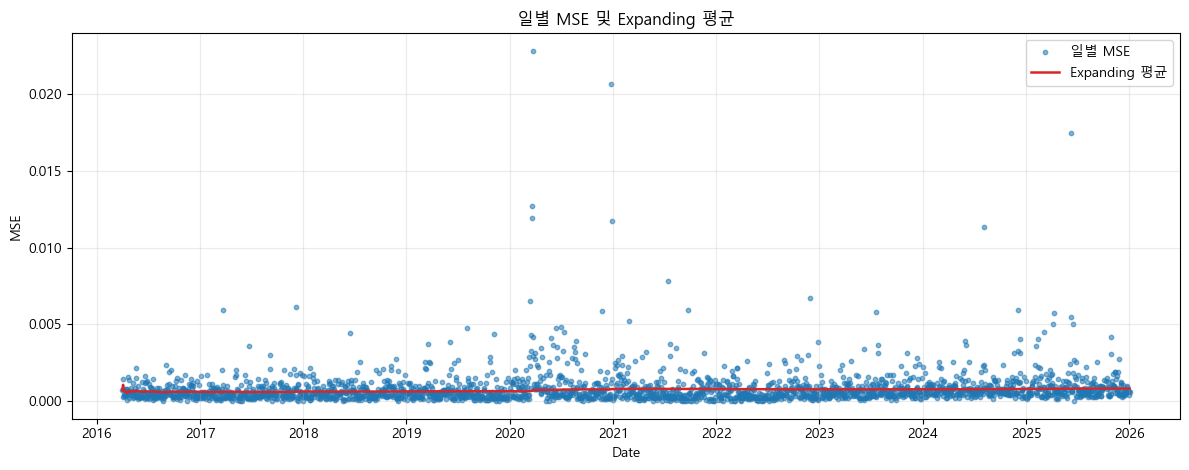

In [ ]:
# 21-2) 일별 MSE 그래프
if ("omega_daily" not in globals()) or (not isinstance(omega_daily, pd.DataFrame)) or omega_daily.empty:
    print("먼저 # 21) 백테스트 실행 셀을 실행하세요.")
else:
    d = omega_daily.copy()
    date_col = "ret_date" if "ret_date" in d.columns else ("view_date" if "view_date" in d.columns else None)

    if date_col is None or ("mse_day" not in d.columns):
        print("omega_daily에 필요한 컬럼(ret_date/view_date, mse_day)이 없습니다.")
    else:
        d[date_col] = pd.to_datetime(d[date_col])
        d = d.sort_values(date_col)
        d["mse_day"] = pd.to_numeric(d["mse_day"], errors="coerce")
        d = d.dropna(subset=["mse_day"]).copy()

        if d.empty:
            print("표시할 mse_day 데이터가 없습니다.")
        else:
            if "omega_day_expanding" not in d.columns:
                d["omega_day_expanding"] = d["mse_day"].expanding().mean()

            use_kr = ("_KR_FONT" in globals()) and (_KR_FONT is not None)
            if use_kr:
                title_txt = "일별 MSE 및 Expanding 평균"
                x_txt = "Date"
                y_txt = "MSE"
                l1 = "일별 MSE"
                l2 = "Expanding 평균"
            else:
                title_txt = "Daily MSE and Expanding Mean"
                x_txt = "Date"
                y_txt = "MSE"
                l1 = "Daily MSE"
                l2 = "Expanding mean"

            fig, ax = plt.subplots(figsize=(12, 4.8))
            ax.scatter(d[date_col], d["mse_day"], s=10, alpha=0.55, label=l1)
            ax.plot(d[date_col], d["omega_day_expanding"], color="tab:red", linewidth=1.8, label=l2)
            ax.set_title(title_txt)
            ax.set_xlabel(x_txt)
            ax.set_ylabel(y_txt)
            ax.grid(alpha=0.25)
            ax.legend(loc="best")
            plt.tight_layout()
            plt.show()

            d[[date_col, "mse_day", "omega_day_expanding"]].tail(10)


In [ ]:
# 22) 성과 요약
ANNUALIZATION = 252

if df_bt.empty:
    summary = pd.DataFrame()
else:
    def make_summary(ret, label):
        ret = ret.dropna()
        cum = (1.0 + ret).cumprod()
        mdd, dd = calc_mdd(cum.values)
        vol = ret.std()
        sh = np.nan if (vol == 0 or np.isnan(vol)) else (ret.mean() / vol) * np.sqrt(ANNUALIZATION)
        s = pd.Series({"Sharpe": sh, "MDD": mdd, "CumulativeReturn": cum.iloc[-1] - 1.0, "AverageDailyReturn": ret.mean(), "Volatility": vol, "N": len(ret)}, name=label)
        return s, cum, dd

    s1, cum, dd = make_summary(df_bt["net_ret"], "BL")
    s2, bcum, bdd = make_summary(df_bt["bm_ret"], "MCap")
    df_bt["cum"], df_bt["drawdown"] = cum, dd
    df_bt["bm_cum"], df_bt["bm_drawdown"] = bcum, bdd
    summary = pd.concat([s1, s2], axis=1)

summary

,BL,MCap
Sharpe,1.107299,0.533101
MDD,-0.542477,-0.405317
CumulativeReturn,11.157866,1.116792
AverageDailyReturn,0.001203,0.000381
Volatility,0.017251,0.011353
N,2368.000000,2368.000000


In [ ]:
# 23) 다중 벤치마크 및 롤링 요약
def _norm(w):
    w = np.asarray(w, dtype=float)
    w = np.where(np.isfinite(w), w, 0.0)
    s = w.sum()
    return (np.ones_like(w) / len(w)) if np.isclose(s, 0.0) else (w / s)


def min_variance_weights(S, long_only=True):
    n = S.shape[0]
    inv = np.linalg.pinv((S + S.T) / 2.0)
    w = inv @ np.ones(n)
    if long_only:
        w = np.clip(w, 0.0, None)
    return _norm(w)


def risk_parity_weights(S, max_iter=500, tol=1e-10):
    n = S.shape[0]
    S = (S + S.T) / 2.0
    w = np.ones(n) / n
    eps = 1e-12
    for _ in range(max_iter):
        m = S @ w
        rc = w * m
        tot = rc.sum()
        if (not np.isfinite(tot)) or (tot <= 0):
            break
        t = tot / n
        wn = np.clip(w * (t / np.clip(rc, eps, None)), eps, None)
        wn = wn / wn.sum()
        if np.max(np.abs(wn - w)) < tol:
            w = wn
            break
        w = wn
    return _norm(w)

bench_rows = []
if not df_bt.empty:
    for next_date, row in tqdm(df_bt.iterrows(), total=len(df_bt), desc="Build benchmarks"):
        vd = pd.to_datetime(row["view_date"])
        uf = eligible_from_series.index[eligible_from_series <= vd].tolist() if len(eligible_from_series) > 0 else None
        try:
            tu, S, _, wm = compute_prior_at_date(vd, ret_simple, mc, WINDOW, MIN_COVERAGE, RISK_AVERSION, uf)
        except Exception:
            continue
        if next_date not in ret_wide.index:
            continue
        rv = ret_wide.loc[next_date, tu].to_numpy(dtype=float)
        m = np.isfinite(rv)
        if m.sum() < 2:
            continue
        rv = rv[m]
        Su = S[np.ix_(m, m)]
        w_ew = np.ones(len(rv)) / len(rv)
        w_mv = min_variance_weights(Su, True)
        w_rp = risk_parity_weights(Su)
        bench_rows.append({"date": pd.to_datetime(next_date), "view_date": vd, "bl_ret": float(row["net_ret"]), "mcap_ret": float(row["bm_ret"]), "ew_ret": float(np.dot(w_ew, rv)), "mv_ret": float(np.dot(w_mv, rv)), "rp_ret": float(np.dot(w_rp, rv))})

bench_daily = pd.DataFrame(bench_rows)
if not bench_daily.empty:
    bench_daily = bench_daily.sort_values("date").set_index("date")

END_DATE_FIXED = pd.Timestamp("2025-12-30")
START_YEARS = list(range(2016, 2025))

def summarize_returns(ret):
    ret = ret.dropna()
    if len(ret) == 0:
        return {"Sharpe": np.nan, "MDD": np.nan, "CumulativeReturn": np.nan, "AverageDailyReturn": np.nan, "Volatility": np.nan, "N": 0}
    cum = (1.0 + ret).cumprod()
    mdd, _ = calc_mdd(cum.values)
    vol = ret.std()
    sh = np.nan if (vol == 0 or np.isnan(vol)) else (ret.mean() / vol) * np.sqrt(ANNUALIZATION)
    return {"Sharpe": float(sh), "MDD": float(mdd), "CumulativeReturn": float(cum.iloc[-1] - 1.0), "AverageDailyReturn": float(ret.mean()), "Volatility": float(vol), "N": int(len(ret))}

rolling_summary_long, rolling_summary_wide = pd.DataFrame(), pd.DataFrame()
if not bench_daily.empty:
    mp = {"BL": "bl_ret", "MCap": "mcap_ret", "EqualWeight": "ew_ret", "MinVariance": "mv_ret", "RiskParity": "rp_ret"}
    rows = []
    for y in START_YEARS:
        st = pd.Timestamp(f"{y}-01-01")
        p = bench_daily.loc[(bench_daily.index >= st) & (bench_daily.index <= END_DATE_FIXED)].copy()
        for n, col in mp.items():
            rows.append({"Window": f"{y}~2025", "StartDate": st.date(), "EndDate": END_DATE_FIXED.date(), "Strategy": n, **summarize_returns(p[col] if col in p.columns else pd.Series(dtype=float))})
    rolling_summary_long = pd.DataFrame(rows)
    rolling_summary_wide = rolling_summary_long.set_index(["Window", "Strategy"])[["Sharpe", "MDD", "CumulativeReturn", "AverageDailyReturn", "Volatility", "N"]].sort_index()

rolling_summary_wide

Build benchmarks:   0%|          | 0/2368 [00:00<?, ?it/s]

Sharpe       MDD  CumulativeReturn  \
Window    Strategy                                            
2016~2025 BL           1.106365 -0.542477         11.121371   
          EqualWeight  0.400704 -0.492533          0.702007   
          MCap         0.519500 -0.405317          1.067129   
          MinVariance  0.286332 -0.442294          0.325122   
          RiskParity   0.197783 -0.498622          0.199890   
2017~2025 BL           1.188936 -0.542477         11.699643   
          EqualWeight  0.458849 -0.492533          0.810854   
          MCap         0.533898 -0.405317          1.026046   
          MinVariance  0.341112 -0.442294          0.393572   
          RiskParity   0.241445 -0.498622          0.272625   
2018~2025 BL           1.140621 -0.542477          8.156931   
          EqualWeight  0.375038 -0.492533          0.520128   
          MCap         0.429371 -0.405317          0.638421   
          MinVariance  0.273361 -0.442294          0.255414   
          RiskParity   0.162968 -0.498622          0.100678   
2019~2025 BL           1.349254 -0.542477          9.908980   
          EqualWeight  0.523905 -0.430799          0.776815   
          MCap         0.625522 -0.344064          1.018833   
          MinVariance  0.450755 -0.372898          0.471113   
          RiskParity   0.282559 -0.498622          0.284512   
2020~2025 BL           1.336376 -0.470311          6.903659   
          EqualWeight  0.520001 -0.406941          0.656209   
          MCap         0.593847 -0.344064          0.798426   
          MinVariance  0.442449 -0.341593          0.399135   
          RiskParity   0.273714 -0.498622          0.231212   
2021~2025 BL           1.611372 -0.251270          5.956070   
          EqualWeight  0.426211 -0.285579          0.338607   
          MCap         0.450993 -0.318743          0.379443   
          MinVariance  0.376339 -0.252054          0.225610   
          RiskParity   0.061167 -0.498622         -0.037193   
2022~2025 BL           1.386360 -0.251270          2.636540   
          EqualWeight  0.272154 -0.248134          0.136234   
          MCap         0.511351 -0.248379          0.358412   
          MinVariance  0.225363 -0.198252          0.087146   
          RiskParity  -0.223229 -0.431670         -0.212682   
2023~2025 BL           1.727738 -0.193696          2.328678   
          EqualWeight  0.727547 -0.215996          0.383882   
          MCap         1.112690 -0.226372          0.765044   
          MinVariance  0.691807 -0.141269          0.274977   
          RiskParity   0.136799 -0.328668          0.022387   
2024~2025 BL           1.815190 -0.193696          1.368834   
          EqualWeight  0.599841 -0.215996          0.200398   
          MCap         1.103709 -0.226372          0.498700   
          MinVariance  0.681871 -0.141269          0.183950   
          RiskParity   0.684571 -0.175930          0.209246   

                       AverageDailyReturn  Volatility     N  
Window    Strategy                                           
2016~2025 BL                     0.001203    0.017254  2367  
          EqualWeight            0.000292    0.011576  2367  
          MCap                   0.000371    0.011345  2367  
          MinVariance            0.000157    0.008713  2367  
          RiskParity             0.000146    0.011751  2367  
2017~2025 BL                     0.001318    0.017601  2184  
          EqualWeight            0.000343    0.011858  2184  
          MCap                   0.000391    0.011626  2184  
          MinVariance            0.000192    0.008949  2184  
          RiskParity             0.000184    0.012087  2184  
2018~2025 BL                     0.001303    0.018136  1944  
          EqualWeight            0.000293    0.012397  1944  
          MCap                   0.000327    0.012102  1944  
          MinVariance            0.000161    0.009355  1944  
          RiskParity             0.000130    0.012678  1944  
2019~2025

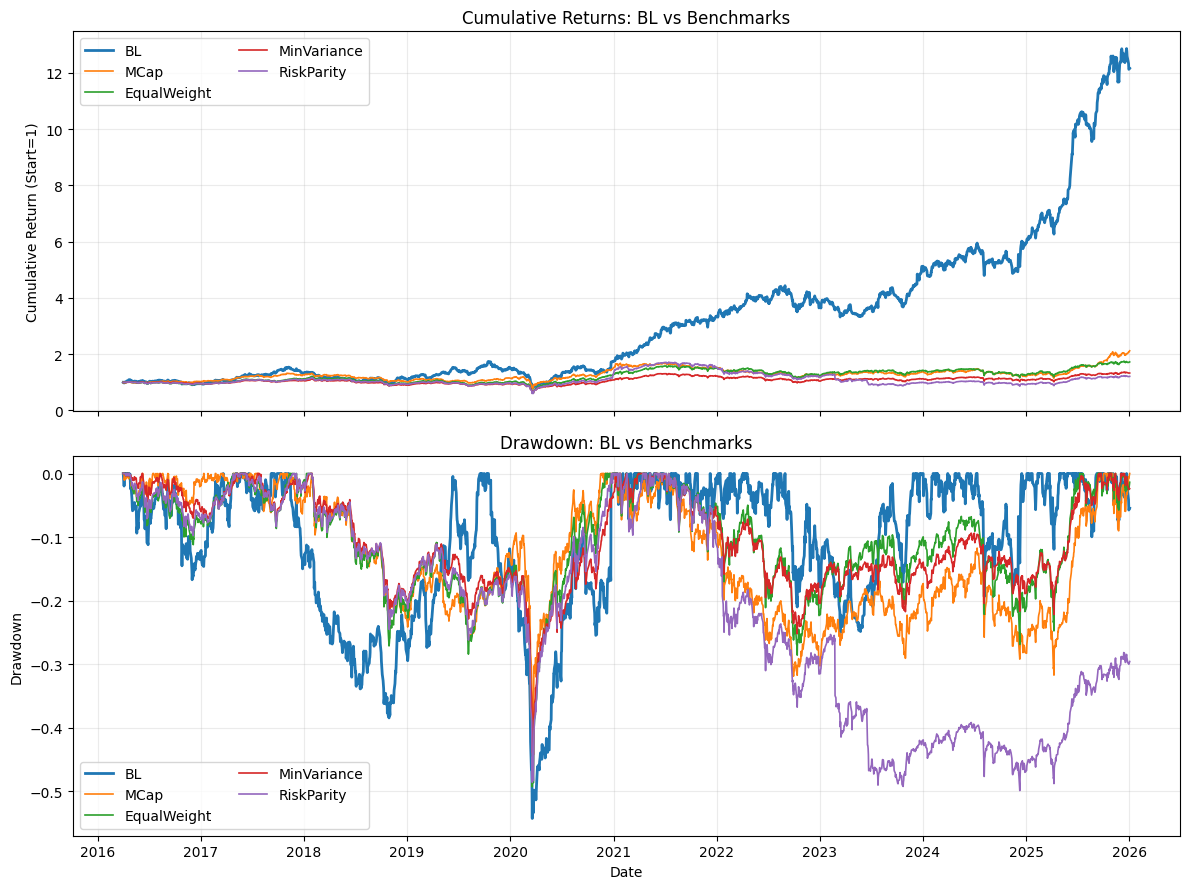

In [ ]:
# 24) 통합 그래프
if bench_daily is None or len(bench_daily) == 0:
    print("No bench_daily data")
else:
    cols = {"BL": "bl_ret", "MCap": "mcap_ret", "EqualWeight": "ew_ret", "MinVariance": "mv_ret", "RiskParity": "rp_ret"}
    cum_df = pd.DataFrame(index=bench_daily.index)
    dd_df = pd.DataFrame(index=bench_daily.index)
    for n, col in cols.items():
        if col in bench_daily.columns:
            s = pd.to_numeric(bench_daily[col], errors="coerce").fillna(0.0)
            cum = (1.0 + s).cumprod()
            dd = (cum / cum.cummax()) - 1.0
            cum_df[n] = cum
            dd_df[n] = dd

    fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
    for c in cum_df.columns:
        axes[0].plot(cum_df.index, cum_df[c], label=c, linewidth=(2.0 if c == "BL" else 1.2))
    axes[0].set_title("Cumulative Returns: BL vs Benchmarks")
    axes[0].set_ylabel("Cumulative Return (Start=1)")
    axes[0].grid(alpha=0.25)
    axes[0].legend(loc="best", ncol=2)

    for c in dd_df.columns:
        axes[1].plot(dd_df.index, dd_df[c], label=c, linewidth=(2.0 if c == "BL" else 1.2))
    axes[1].set_title("Drawdown: BL vs Benchmarks")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Drawdown")
    axes[1].grid(alpha=0.25)
    axes[1].legend(loc="best", ncol=2)
    plt.tight_layout()
    plt.show()


In [ ]:
# 25) 결과 저장
from pathlib import Path
EXPORT_PATH = Path("backtest") / "final_outputs.xlsx"
EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)

config_df = pd.DataFrame([
    {"key": "DATA_START_DATE", "value": DATA_START_DATE},
    {"key": "RAW_TARGET_RETURN_COL", "value": RAW_TARGET_RETURN_COL},
    {"key": "MODEL_TARGET_COL", "value": MODEL_TARGET_COL},
    {"key": "BACKTEST_RETURN_COL", "value": BACKTEST_RETURN_COL},
    {"key": "WINDOW", "value": WINDOW},
    {"key": "MIN_REPORT_COUNT", "value": MIN_REPORT_COUNT},
    {"key": "RIDGE_ALPHA_DEFAULT", "value": RIDGE_ALPHA_DEFAULT},
    {"key": "ridge_alpha_used", "value": float(globals().get("ridge_alpha_used", RIDGE_ALPHA_DEFAULT))},
    {"key": "MODEL_TYPE", "value": globals().get("MODEL_TYPE", "ridge")},
])

with pd.ExcelWriter(EXPORT_PATH, engine="openpyxl") as w:
    config_df.to_excel(w, sheet_name="config", index=False)
    if isinstance(alpha_summary, pd.DataFrame) and len(alpha_summary) > 0: alpha_summary.to_excel(w, sheet_name="alpha_summary", index=False)
    if isinstance(alpha_daily, pd.DataFrame) and len(alpha_daily) > 0: alpha_daily.to_excel(w, sheet_name="alpha_daily", index=False)
    if isinstance(df_pred, pd.DataFrame) and len(df_pred) > 0: df_pred.to_excel(w, sheet_name="model_predictions", index=False)
    if isinstance(df_view, pd.DataFrame) and len(df_view) > 0: df_view.to_excel(w, sheet_name="views", index=False)
    if isinstance(df_bt, pd.DataFrame) and len(df_bt) > 0: df_bt.reset_index().to_excel(w, sheet_name="backtest_daily", index=False)
    if isinstance(weights_history, pd.DataFrame) and len(weights_history) > 0: weights_history.to_excel(w, sheet_name="weights_long", index=False)
    if isinstance(omega_daily, pd.DataFrame) and len(omega_daily) > 0: omega_daily.to_excel(w, sheet_name="omega_daily", index=False)
    if isinstance(bench_daily, pd.DataFrame) and len(bench_daily) > 0: bench_daily.reset_index().to_excel(w, sheet_name="bench_daily", index=False)
    if isinstance(rolling_summary_long, pd.DataFrame) and len(rolling_summary_long) > 0: rolling_summary_long.to_excel(w, sheet_name="rolling_summary_long", index=False)
    if isinstance(rolling_summary_wide, pd.DataFrame) and len(rolling_summary_wide) > 0: rolling_summary_wide.to_excel(w, sheet_name="rolling_summary_wide")
    if isinstance(summary, pd.DataFrame) and len(summary) > 0: summary.to_excel(w, sheet_name="summary")

print(f"saved: {EXPORT_PATH}")


# Ver.2

In [50]:
# 21) 백테스트 실행
RISK_AVERSION = 2.5
OMEGA_MIN_OBS = 20
OMEGA_FALLBACK_MSE = 1e-4
MIN_COVERAGE = 1.0
TAU = 0.05
LONG_ONLY = True
WEIGHT_CLIP = None
TRANSACTION_COST_BPS = 0.0
SELL_TAX_BPS = 0.0
HOLD_IF_COST_EXCEEDS_EXPECTED = True

ret_index = ret_wide.index
omega_day_sse, omega_day_cnt = 0.0, 0
omega_daily_hist = []
results, weights_hist = [], []
prev_w, prev_tickers = None, None
eligible_from_series = ticker_eligible_from.sort_values() if isinstance(ticker_eligible_from, pd.Series) else pd.Series(dtype="datetime64[ns]")

for view_date in tqdm(view_dates, desc="Backtest", total=len(view_dates)):
    try:
        uf = eligible_from_series.index[eligible_from_series <= pd.to_datetime(view_date)].tolist() if len(eligible_from_series) > 0 else None
        tu, S, Pi, wm = compute_prior_at_date(view_date, ret_simple, mc, WINDOW, MIN_COVERAGE, RISK_AVERSION, uf)
        tv, Qlog = align_view_to_prior(df_view_by_date, view_date, tu)
        Q = np.expm1(np.asarray(Qlog, dtype=float))
        if len(Q) == 0:
            continue
        P = build_pick_matrix(tu, tv)
        tau = (1.0 / len(tu)) if TAU is None else float(TAU)
        omega_level = get_omega_level(omega_day_sse, omega_day_cnt, OMEGA_MIN_OBS, OMEGA_FALLBACK_MSE)
        Omega = np.eye(len(Q), dtype=float) * omega_level

        live = pd.to_datetime(view_date) >= pd.to_datetime(backtest_start)
        if live:
            mu = black_litterman_posterior(Pi, S, P, Q, Omega, tau)
            w = compute_bl_weights(mu, S, RISK_AVERSION, LONG_ONLY, WEIGHT_CLIP)
            w_bm = wm / np.sum(wm) if not np.isclose(np.sum(wm), 0) else np.ones_like(wm) / len(wm)
        else:
            w, w_bm, mu = None, None, None
    except Exception:
        continue

    if view_date not in ret_index:
        continue
    loc = ret_index.get_loc(view_date)
    loc = loc if isinstance(loc, (int, np.integer)) else loc.start
    ret_pos = loc + h_bt
    if ret_pos >= len(ret_index):
        continue

    ret_date = ret_index[ret_pos]
    ret_vec = ret_wide.loc[ret_date, tu].values.astype(float)
    tick_ret = np.array(tu, dtype=str)

    ps = pd.Series(Q, index=tv)
    rs = pd.Series(ret_vec, index=tick_ret)
    omega_day_sse, omega_day_cnt, omega_daily_hist = update_omega_state(ps, rs, omega_day_sse, omega_day_cnt, omega_daily_hist, view_date, ret_date)

    if pd.to_datetime(view_date) < pd.to_datetime(backtest_start):
        continue

    mu_vec = np.asarray(mu, dtype=float)

    if np.isnan(ret_vec).any():
        m = ~np.isnan(ret_vec)
        if m.sum() < 2:
            continue
        ret_vec = ret_vec[m]
        w = w[m]
        w = w / w.sum()
        w_bm = w_bm[m]
        w_bm = w_bm / w_bm.sum()
        tick_ret = tick_ret[m]
        mu_vec = mu_vec[m]

    n_hold_assets = 0
    if HOLD_IF_COST_EXCEEDS_EXPECTED and (prev_w is not None) and (prev_tickers is not None):
        prev_aligned = pd.Series(prev_w, index=prev_tickers).reindex(tick_ret).fillna(0.0).values
        delta_w = w - prev_aligned
        tc_rate = float(TRANSACTION_COST_BPS) * 1e-4
        sell_tax_rate = float(SELL_TAX_BPS) * 1e-4
        cost_i = np.abs(delta_w) * tc_rate + np.maximum(-delta_w, 0.0) * sell_tax_rate
        expected_gain_i = delta_w * mu_vec
        hold_mask = expected_gain_i <= cost_i

        if hold_mask.any():
            w = w.copy()
            w[hold_mask] = prev_aligned[hold_mask]
            ws = w.sum()
            if (not np.isfinite(ws)) or (ws <= 0):
                w = np.ones_like(w) / len(w)
            else:
                w = w / ws
            n_hold_assets = int(hold_mask.sum())

    turnover, sell_turnover = compute_turnover_and_sell(prev_w, prev_tickers, w, tick_ret)
    cost = compute_cost(turnover, sell_turnover, TRANSACTION_COST_BPS, SELL_TAX_BPS)
    port_ret = float(np.dot(w, ret_vec)) - cost
    bm_ret = float(np.dot(w_bm, ret_vec))

    results.append({
        "view_date": pd.to_datetime(view_date),
        "next_date": pd.to_datetime(ret_date),
        "net_ret": port_ret,
        "bm_ret": bm_ret,
        "cost": cost,
        "omega_used": omega_level,
        "n_assets": len(w),
        "n_hold_assets": n_hold_assets,
    })
    weights_hist.append(pd.DataFrame({"date": pd.to_datetime(view_date), "ticker_code": tick_ret, "weight": w}))
    prev_w, prev_tickers = w, tick_ret

if len(results) == 0:
    df_bt = pd.DataFrame(); weights_history = pd.DataFrame(); omega_daily = pd.DataFrame()
else:
    df_bt = pd.DataFrame(results).sort_values("next_date").set_index("next_date")
    weights_history = pd.concat(weights_hist, ignore_index=True)
    omega_daily = pd.DataFrame(omega_daily_hist)

df_bt


Backtest:   0%|          | 0/2370 [00:00<?, ?it/s]

,view_date,net_ret,bm_ret,cost,omega_used,n_assets,n_hold_assets
next_date,,,,,,,
2016-04-01,2016-03-31,-0.004568,-0.011581,0.0,0.000100,140,0
2016-04-04,2016-04-01,-0.016892,0.003682,0.0,0.000100,140,96
2016-04-05,2016-04-04,0.003891,-0.010470,0.0,0.000100,140,126
2016-04-06,2016-04-05,0.025869,0.004304,0.0,0.000100,140,65
2016-04-07,2016-04-06,0.001936,0.001007,0.0,0.000100,140,113
...,...,...,...,...,...,...,...
2025-12-24,2025-12-23,-0.006466,-0.002293,0.0,0.000824,625,52
2025-12-26,2025-12-24,-0.006458,0.005768,0.0,0.000824,625,57
2025-12-29,2025-12-26,0.009347,0.021924,0.0,0.000824,625,52


In [51]:
# 22) 성과 요약
ANNUALIZATION = 252

if df_bt.empty:
    summary = pd.DataFrame()
else:
    def make_summary(ret, label):
        ret = ret.dropna()
        cum = (1.0 + ret).cumprod()
        mdd, dd = calc_mdd(cum.values)
        vol = ret.std()
        sh = np.nan if (vol == 0 or np.isnan(vol)) else (ret.mean() / vol) * np.sqrt(ANNUALIZATION)
        s = pd.Series({"Sharpe": sh, "MDD": mdd, "CumulativeReturn": cum.iloc[-1] - 1.0, "AverageDailyReturn": ret.mean(), "Volatility": vol, "N": len(ret)}, name=label)
        return s, cum, dd

    s1, cum, dd = make_summary(df_bt["net_ret"], "BL")
    s2, bcum, bdd = make_summary(df_bt["bm_ret"], "MCap")
    df_bt["cum"], df_bt["drawdown"] = cum, dd
    df_bt["bm_cum"], df_bt["bm_drawdown"] = bcum, bdd
    summary = pd.concat([s1, s2], axis=1)

summary

,BL,MCap
Sharpe,0.751668,0.533101
MDD,-0.469334,-0.405317
CumulativeReturn,2.324162,1.116792
AverageDailyReturn,0.000583,0.000381
Volatility,0.012322,0.011353
N,2368.000000,2368.000000


In [52]:
# 23) 다중 벤치마크 및 롤링 요약
def _norm(w):
    w = np.asarray(w, dtype=float)
    w = np.where(np.isfinite(w), w, 0.0)
    s = w.sum()
    return (np.ones_like(w) / len(w)) if np.isclose(s, 0.0) else (w / s)


def min_variance_weights(S, long_only=True):
    n = S.shape[0]
    inv = np.linalg.pinv((S + S.T) / 2.0)
    w = inv @ np.ones(n)
    if long_only:
        w = np.clip(w, 0.0, None)
    return _norm(w)


def risk_parity_weights(S, max_iter=500, tol=1e-10):
    n = S.shape[0]
    S = (S + S.T) / 2.0
    w = np.ones(n) / n
    eps = 1e-12
    for _ in range(max_iter):
        m = S @ w
        rc = w * m
        tot = rc.sum()
        if (not np.isfinite(tot)) or (tot <= 0):
            break
        t = tot / n
        wn = np.clip(w * (t / np.clip(rc, eps, None)), eps, None)
        wn = wn / wn.sum()
        if np.max(np.abs(wn - w)) < tol:
            w = wn
            break
        w = wn
    return _norm(w)


def apply_hold_and_cost(target_w, prev_w, prev_tickers, tickers, mu_proxy, tc_bps, sell_tax_bps, use_hold):
    target_w = _norm(target_w)
    n_hold = 0

    if (prev_w is not None) and (prev_tickers is not None):
        prev_aligned = pd.Series(prev_w, index=prev_tickers).reindex(tickers).fillna(0.0).values
        delta_w = target_w - prev_aligned
        tc_rate = float(tc_bps) * 1e-4
        sell_tax_rate = float(sell_tax_bps) * 1e-4
        cost_i = np.abs(delta_w) * tc_rate + np.maximum(-delta_w, 0.0) * sell_tax_rate
        expected_gain_i = delta_w * np.asarray(mu_proxy, dtype=float)

        if use_hold:
            hold_mask = expected_gain_i <= cost_i
            if hold_mask.any():
                target_w = target_w.copy()
                target_w[hold_mask] = prev_aligned[hold_mask]
                target_w = _norm(target_w)
                n_hold = int(hold_mask.sum())

    turnover, sell_turnover = compute_turnover_and_sell(prev_w, prev_tickers, target_w, tickers)
    cost = compute_cost(turnover, sell_turnover, tc_bps, sell_tax_bps)
    return target_w, cost, n_hold


bench_rows = []
if not df_bt.empty:
    tc_bps = float(TRANSACTION_COST_BPS) if "TRANSACTION_COST_BPS" in globals() else 0.0
    sell_tax_bps = float(SELL_TAX_BPS) if "SELL_TAX_BPS" in globals() else 0.0
    hold_by_cost = bool(HOLD_IF_COST_EXCEEDS_EXPECTED) if "HOLD_IF_COST_EXCEEDS_EXPECTED" in globals() else False

    prev_state = {
        "MCap": {"w": None, "tickers": None},
        "EqualWeight": {"w": None, "tickers": None},
        "MinVariance": {"w": None, "tickers": None},
        "RiskParity": {"w": None, "tickers": None},
    }

    for next_date, row in tqdm(df_bt.iterrows(), total=len(df_bt), desc="Build benchmarks"):
        vd = pd.to_datetime(row["view_date"])
        uf = eligible_from_series.index[eligible_from_series <= vd].tolist() if len(eligible_from_series) > 0 else None
        try:
            tu, S, Pi, wm = compute_prior_at_date(vd, ret_simple, mc, WINDOW, MIN_COVERAGE, RISK_AVERSION, uf)
        except Exception:
            continue

        if next_date not in ret_wide.index:
            continue

        rv_full = ret_wide.loc[next_date, tu].to_numpy(dtype=float)
        m = np.isfinite(rv_full)
        if m.sum() < 2:
            continue

        rv = rv_full[m]
        tick_u = np.asarray(tu, dtype=str)[m]
        Su = S[np.ix_(m, m)]
        pi_u = np.asarray(Pi, dtype=float)[m]
        wm_u = _norm(np.asarray(wm, dtype=float)[m])

        cand = {
            "MCap": wm_u,
            "EqualWeight": np.ones(len(rv)) / len(rv),
            "MinVariance": min_variance_weights(Su, True),
            "RiskParity": risk_parity_weights(Su),
        }

        out_ret = {}
        out_cost = {}
        out_hold = {}

        for name, w_target in cand.items():
            st = prev_state[name]
            w_exec, c_exec, n_hold = apply_hold_and_cost(
                target_w=w_target,
                prev_w=st["w"],
                prev_tickers=st["tickers"],
                tickers=tick_u,
                mu_proxy=pi_u,
                tc_bps=tc_bps,
                sell_tax_bps=sell_tax_bps,
                use_hold=hold_by_cost,
            )
            out_ret[name] = float(np.dot(w_exec, rv)) - c_exec
            out_cost[name] = float(c_exec)
            out_hold[name] = int(n_hold)
            prev_state[name] = {"w": w_exec, "tickers": tick_u}

        bench_rows.append({
            "date": pd.to_datetime(next_date),
            "view_date": vd,
            "bl_ret": float(row["net_ret"]),
            "mcap_ret": out_ret["MCap"],
            "ew_ret": out_ret["EqualWeight"],
            "mv_ret": out_ret["MinVariance"],
            "rp_ret": out_ret["RiskParity"],
            "mcap_cost": out_cost["MCap"],
            "ew_cost": out_cost["EqualWeight"],
            "mv_cost": out_cost["MinVariance"],
            "rp_cost": out_cost["RiskParity"],
            "mcap_hold_n": out_hold["MCap"],
            "ew_hold_n": out_hold["EqualWeight"],
            "mv_hold_n": out_hold["MinVariance"],
            "rp_hold_n": out_hold["RiskParity"],
        })

bench_daily = pd.DataFrame(bench_rows)
if not bench_daily.empty:
    bench_daily = bench_daily.sort_values("date").set_index("date")

END_DATE_FIXED = pd.Timestamp("2025-12-30")
START_YEARS = list(range(2016, 2025))

def summarize_returns(ret):
    ret = ret.dropna()
    if len(ret) == 0:
        return {"Sharpe": np.nan, "MDD": np.nan, "CumulativeReturn": np.nan, "AverageDailyReturn": np.nan, "Volatility": np.nan, "N": 0}
    cum = (1.0 + ret).cumprod()
    mdd, _ = calc_mdd(cum.values)
    vol = ret.std()
    sh = np.nan if (vol == 0 or np.isnan(vol)) else (ret.mean() / vol) * np.sqrt(ANNUALIZATION)
    return {"Sharpe": float(sh), "MDD": float(mdd), "CumulativeReturn": float(cum.iloc[-1] - 1.0), "AverageDailyReturn": float(ret.mean()), "Volatility": float(vol), "N": int(len(ret))}

rolling_summary_long, rolling_summary_wide = pd.DataFrame(), pd.DataFrame()
if not bench_daily.empty:
    mp = {"BL": "bl_ret", "MCap": "mcap_ret", "EqualWeight": "ew_ret", "MinVariance": "mv_ret", "RiskParity": "rp_ret"}
    rows = []
    for y in START_YEARS:
        st = pd.Timestamp(f"{y}-01-01")
        p = bench_daily.loc[(bench_daily.index >= st) & (bench_daily.index <= END_DATE_FIXED)].copy()
        for n, col in mp.items():
            rows.append({"Window": f"{y}~2025", "StartDate": st.date(), "EndDate": END_DATE_FIXED.date(), "Strategy": n, **summarize_returns(p[col] if col in p.columns else pd.Series(dtype=float))})
    rolling_summary_long = pd.DataFrame(rows)
    rolling_summary_wide = rolling_summary_long.set_index(["Window", "Strategy"])[["Sharpe", "MDD", "CumulativeReturn", "AverageDailyReturn", "Volatility", "N"]].sort_index()

rolling_summary_wide

Build benchmarks:   0%|          | 0/2368 [00:00<?, ?it/s]

Sharpe       MDD  CumulativeReturn  \
Window    Strategy                                            
2016~2025 BL           0.745102 -0.469334          2.282684   
          EqualWeight  0.398788 -0.492524          0.696402   
          MCap         0.526530 -0.403241          1.094008   
          MinVariance  0.293498 -0.441757          0.342889   
          RiskParity   0.279705 -0.483806          0.359553   
2017~2025 BL           0.816765 -0.469334          2.457089   
          EqualWeight  0.456819 -0.492524          0.804884   
          MCap         0.540399 -0.403241          1.049333   
          MinVariance  0.347115 -0.441757          0.411084   
          RiskParity   0.332320 -0.483806          0.441521   
2018~2025 BL           0.698802 -0.469334          1.588714   
          EqualWeight  0.372859 -0.492524          0.515117   
          MCap         0.435120 -0.403241          0.653570   
          MinVariance  0.277814 -0.441757          0.265650   
          RiskParity   0.249807 -0.483806          0.246940   
2019~2025 BL           0.939188 -0.432510          2.305545   
          EqualWeight  0.521453 -0.430801          0.770916   
          MCap         0.628223 -0.345166          1.028390   
          MinVariance  0.445900 -0.376278          0.473013   
          RiskParity   0.392449 -0.420419          0.452742   
2020~2025 BL           0.886597 -0.402967          1.698990   
          EqualWeight  0.517265 -0.406941          0.650712   
          MCap         0.595810 -0.345166          0.804453   
          MinVariance  0.437187 -0.344847          0.399957   
          RiskParity   0.391317 -0.385920          0.390463   
2021~2025 BL           0.979200 -0.234680          1.326652   
          EqualWeight  0.423212 -0.286797          0.335103   
          MCap         0.453091 -0.318982          0.382518   
          MinVariance  0.370862 -0.252960          0.224309   
          RiskParity   0.256882 -0.333763          0.148905   
2022~2025 BL           0.887397 -0.234680          0.849123   
          EqualWeight  0.271477 -0.248134          0.135686   
          MCap         0.515059 -0.249144          0.362648   
          MinVariance  0.225651 -0.198337          0.088156   
          RiskParity   0.161086 -0.285200          0.050779   
2023~2025 BL           1.486309 -0.234680          1.250177   
          EqualWeight  0.727589 -0.215993          0.383912   
          MCap         1.116584 -0.226729          0.769973   
          MinVariance  0.683198 -0.145554          0.275186   
          RiskParity   0.776298 -0.175558          0.364292   
2024~2025 BL           1.385997 -0.234680          0.703705   
          EqualWeight  0.599859 -0.215993          0.200406   
          MCap         1.102870 -0.226729          0.498579   
          MinVariance  0.654703 -0.145554          0.177923   
          RiskParity   0.679809 -0.175558          0.207090   

                       AverageDailyReturn  Volatility     N  
Window    Strategy                                           
2016~2025 BL                     0.000578    0.012323  2367  
          EqualWeight            0.000291    0.011576  2367  
          MCap                   0.000377    0.011365  2367  
          MinVariance            0.000164    0.008889  2367  
          RiskParity             0.000186    0.010544  2367  
2017~2025 BL                     0.000647    0.012584  2184  
          EqualWeight            0.000341    0.011859  2184  
          MCap                   0.000396    0.011647  2184  
          MinVariance            0.000200    0.009132  2184  
          RiskParity             0.000226    0.010814  2184  
2018~2025 BL                     0.000575    0.013059  1944  
          EqualWeight            0.000291    0.012397  1944  
          MCap                   0.000332    0.012125  1944  
          MinVariance            0.000167    0.009549  1944  
          RiskParity             0.000178    0.011313  1944  
2019~2025

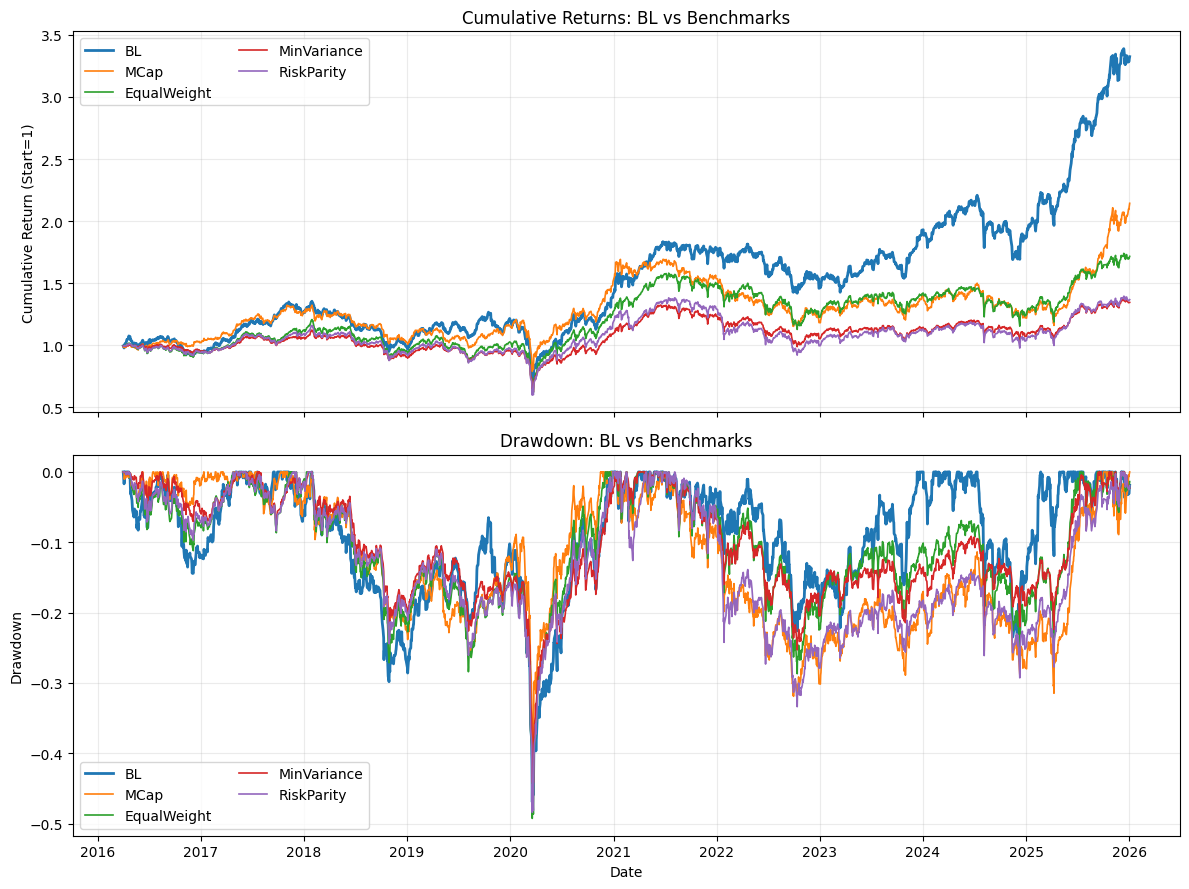

In [53]:
# 24) 통합 그래프
if bench_daily is None or len(bench_daily) == 0:
    print("No bench_daily data")
else:
    cols = {"BL": "bl_ret", "MCap": "mcap_ret", "EqualWeight": "ew_ret", "MinVariance": "mv_ret", "RiskParity": "rp_ret"}
    cum_df = pd.DataFrame(index=bench_daily.index)
    dd_df = pd.DataFrame(index=bench_daily.index)
    for n, col in cols.items():
        if col in bench_daily.columns:
            s = pd.to_numeric(bench_daily[col], errors="coerce").fillna(0.0)
            cum = (1.0 + s).cumprod()
            dd = (cum / cum.cummax()) - 1.0
            cum_df[n] = cum
            dd_df[n] = dd

    fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
    for c in cum_df.columns:
        axes[0].plot(cum_df.index, cum_df[c], label=c, linewidth=(2.0 if c == "BL" else 1.2))
    axes[0].set_title("Cumulative Returns: BL vs Benchmarks")
    axes[0].set_ylabel("Cumulative Return (Start=1)")
    axes[0].grid(alpha=0.25)
    axes[0].legend(loc="best", ncol=2)

    for c in dd_df.columns:
        axes[1].plot(dd_df.index, dd_df[c], label=c, linewidth=(2.0 if c == "BL" else 1.2))
    axes[1].set_title("Drawdown: BL vs Benchmarks")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Drawdown")
    axes[1].grid(alpha=0.25)
    axes[1].legend(loc="best", ncol=2)
    plt.tight_layout()
    plt.show()